### Modeling Volatility and VaR

#### Helper Functions

In [7]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


rets = pd.read_excel(r'\Users\anyae\Downloads\barnstable_analysis_data.xlsx', sheet_name=1)
rets.set_index('date', inplace=True)
rets.fillna(method='ffill', inplace=True)
rets['Excess SPY Returns'] = rets['SPX'] - rets['TB1M'] 
rets.head()

,SPX,TB1M,Excess SPY Returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


#### 1.1 Historic VaR

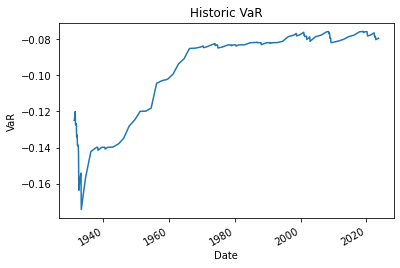

5% VaR backtest: 3.15%


In [8]:
historic_VaR = rets['Excess SPY Returns'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()


plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

exceed = sum(rets['Excess SPY Returns'] < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

###### What drawbacks do you see in this historic VaR?
Some drawbacks of historic VaR:
- it puts equal weight on past events that might no longer be relevant, for example, low returns in 2008 are given the same weight as recent obseverations.
- Historic VaR is also slow to react, it put less weight on more recent observations in the sense that it puts the same weight on recent and historic observations even though the recent ones may be more relevant.
- Backward Looking: Looks at only the historical data while estimating the losses in the future. Availability of sufficient and relevant data becomes a challenge.


#### 1.2 Volatility

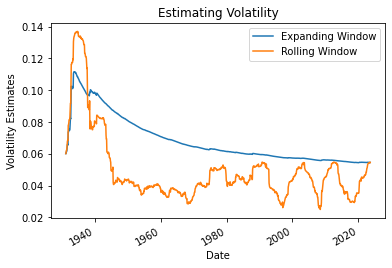

In [9]:
stdev = np.sqrt((rets['Excess SPY Returns']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))
stdev['Rolling Window'] = np.sqrt((rets['Excess SPY Returns']**2).shift(1).rolling(60).mean())
stdev.plot()
plt.title('Estimating Volatility')
plt.ylabel('Volatility Estimates')
plt.xlabel('Date')
plt.show()

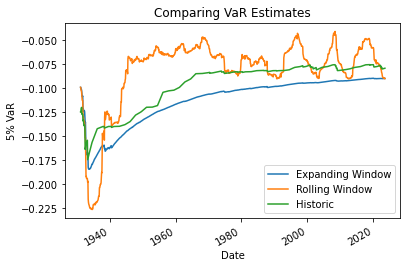

In [10]:
VaR = -1.65*stdev
VaR['Historic'] = historic_VaR

VaR.plot()
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

In [11]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[rets.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic
Frequency,1.80%,4.95%,3.15%


Rolling window is a much better estimate because it place more weight on the most recent observations, and hence is quicker to react to high volatilities than other methods.

#### 1.3 CVaR

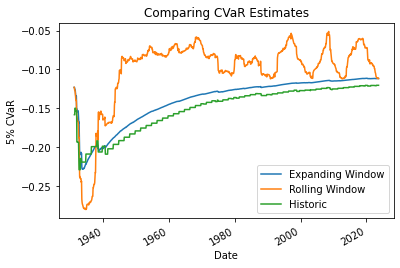

In [13]:
historic_CVaR = []

for i in range(len(rets)):
    if i < 61:
        historic_CVaR.append(np.nan)
    else:
        window = rets[['Excess SPY Returns']][:i-1]
        CVaR = window[window < window.quantile(0.05)]['Excess SPY Returns'].mean()
        historic_CVaR.append(CVaR)

scaling_for_vol = norm.pdf(1.65)/0.05 #trucated normal

CVaR = -scaling_for_vol * stdev

CVaR['Historic'] = historic_CVaR

CVaR.plot()
plt.title('Comparing CVaR Estimates')
plt.ylabel('5% CVaR')
plt.xlabel('Date')
plt.show()

### 3 Estimating Underperformance

#### 1. Summary Statistics

In [15]:
stats_table = pd.DataFrame(
            index = pd.MultiIndex.from_tuples([('levels', 'SPX'),('levels', 'RiskFree'),('levels', 'Excess SPX'),
                                              ('logs', 'SPX'),('logs', 'RiskFree'), ('logs', 'Excess SPX')]),
            columns = pd.MultiIndex.from_tuples([('1965-1999','mean'),('1965-1999','vol'),
                                                ('2000-2022','mean'),('2000-2022','vol'),
                                                ('1926-2022','mean'),('1926-2022','vol')]))

stats_table[('1965-1999','mean')] = list(np.mean(rets.loc['1965':'1999']) * 12) + list(np.mean(np.log(1+rets.loc['1965':'1999']))*12)
stats_table[('1965-1999','vol')] = list(np.std(rets.loc['1965':'1999']) * np.sqrt(12)) + list(np.std(np.log(1+rets.loc['1965':'1999'])) * np.sqrt(12))
stats_table[('2000-2022','mean')] = list(np.mean(rets.loc['2000':'2022']) * 12) + list(np.mean(np.log(1+rets.loc['2000':'2022']))*12)
stats_table[('2000-2022','vol')] = list(np.std(rets.loc['2000':'2022']) * np.sqrt(12)) + list(np.std(np.log(1+rets.loc['2000':'2022'])) * np.sqrt(12))
stats_table[('1926-2022','mean')] = list(np.mean(rets) * 12) + list(np.mean(np.log(1+rets))*12)
stats_table[('1926-2022','vol')] = list(np.std(rets) * np.sqrt(12)) + list(np.std(np.log(1+rets)) * np.sqrt(12))

display(stats_table.style.format('{:,.2%}'))

Full sample estimates are significantly different for the excess returns, this is because of the low risk-free rate during that period. The log returns show lower mean returns as expected.

#### 3.2 

In [16]:
def prob(mu, sigma, h):
    return norm.cdf(-np.sqrt(h)*mu/sigma)

mu = stats_table[('1965-1999', 'mean')][('logs', 'Excess SPX')]
sigma = stats_table[('1965-1999', 'vol')][('logs', 'Excess SPX')]

print('Probability of SPX underperforming RF in the next 15 years after 1999: {:,.2%}'.
      format(prob(mu = mu, sigma = sigma, h = 15)))

print('Probability of SPX underperforming RF in the next 30 years after 1999: {:,.2%}'.
      format(prob(mu = mu, sigma = sigma, h = 30)))

Probability of SPX underperforming RF in the next 15 years after 1999: 7.39%
Probability of SPX underperforming RF in the next 30 years after 1999: 2.03%


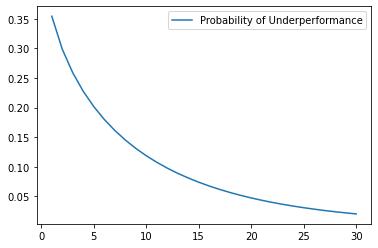

In [17]:
h = list(range(1, 31))
probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()
plt.show()

#### 3.3 
Use the sample 1965-2023 to reconsider the 30-year probability. As of the end of 2023, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years.

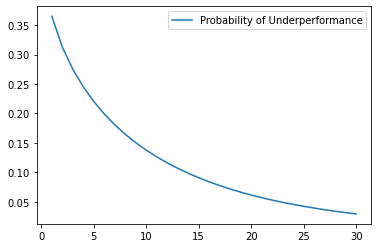

In [18]:
mu = np.log(1+rets['Excess SPY Returns'].loc['1965':'2022']).mean() * 12
sigma = np.log(1+rets['Excess SPY Returns'].loc['1965':'2022']).std() * np.sqrt(12)
h = list(range(1, 31))

probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()
plt.show()

#### 3.4 

In [19]:
mu = stats_table[('1965-1999', 'mean')][('logs', 'SPX')] - stats_table[('2000-2022', 'mean')][('logs', 'SPX')]
sigma = stats_table[('1965-1999', 'vol')][('logs', 'SPX')]

print('Probability of SPX underperforming in the next 23 years after 1999: {:,.2%}'.
      format(prob(mu = mu, sigma = sigma, h = 23)))

Probability of SPX underperforming in the next 23 years after 1999: 3.70%


In [20]:
strike = np.log(1.06)

mean_return = np.log(1+rets['SPX'].loc['1965':]).mean() * 12

sigma = np.log(1 + rets['SPX'].loc['1965':]).std() * np.sqrt(12)

performance = np.log(1+rets['SPX'].loc['2000':]).mean() * 12

mu = ((23/7) * (performance - strike)) - (mean_return - strike)

print('Probability of Puts ending in the money: {:,.2%}'.
      format(prob(mu, sigma, 7)))

Probability of Puts ending in the money: 55.94%
